# Tonti Diagram Elastic Beam Deflection Demo
This notebook demonstrates an example of the current interface for the definition and execution of Tonti diagrams.

In [1]:
#== Import required libraries ==#
using Catlab.Graphs
using Catlab.Graphics
using Catlab.CategoricalAlgebra
using CombinatorialSpaces
using Distributions
using CairoMakie
using DifferentialEquations
using AlgebraicDynamics.TontiDiagrams

In [2]:
# helper function for setting initial conditions
function gen_form(s::EmbeddedDeltaSet2D, f::Function)
  map(f, point(s))
end

gen_form (generic function with 1 method)

## Import a mesh for the physics
We begin by importing a mesh which the DEC operators will be defined on. Our goal is to have application of a physics to a mesh be the last step (after defining the physics in a Tonti diagram).

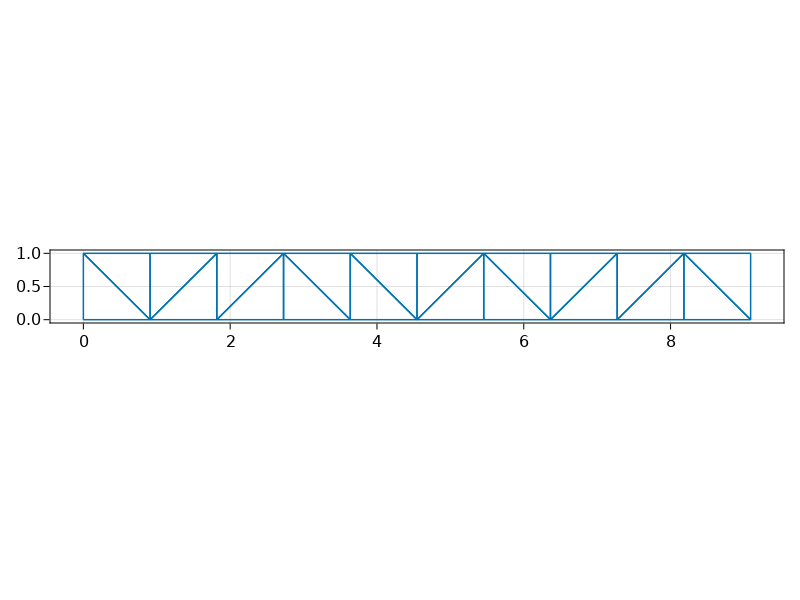

In [4]:
s = EmbeddedDeltaSet2D("truss_v1.obj");
sp = Space(s)
sd = sp.sd;
figure, axis, ob = wireframe(s)
axis.aspect = AxisAspect(10/1)
figure

## Define boundaries
Currently boundaries are obtained through calculating all boundary edges, then filtering by location for appropriate specific boundaries. This will be replaced with a connected components algorithm, which can present each individual boundary automatically.

In [5]:
# Get boundary masks for BCs #
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s))) # mesh edges
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt])) # mesh edge vertices

# Define vertices for BC application 
left = filter(x->all((0.0,0.0,0.0) .<= s[x,:point] .<= (0,1.0,0.0)), boundary_v) # fixed end
load_v = [22]; # free end load application point

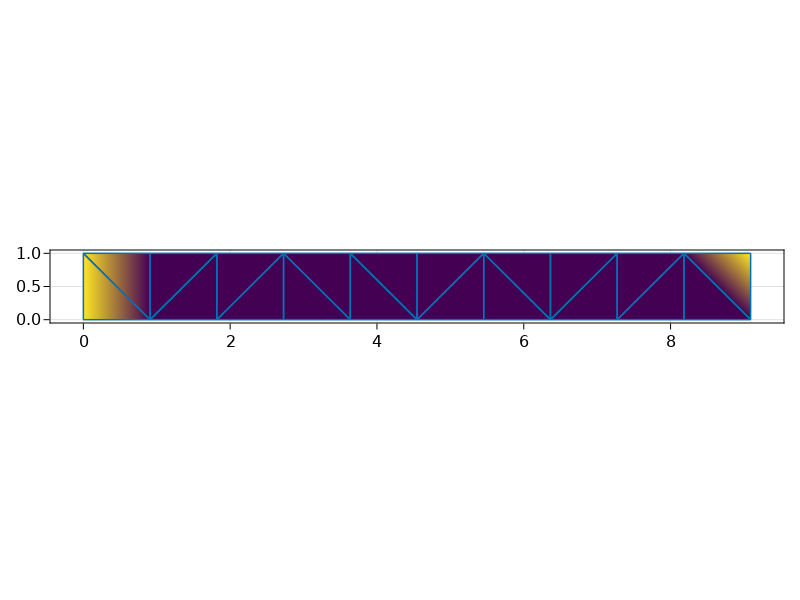

In [6]:
boundary_indices = [1, 2, 22]
colors = zeros(nv(s)) # Generate a 0-form (array with the same number of elements as there are points
colors[boundary_indices] .= 1 # "highlight" the boundary vertices
fig, ax, ob = mesh(s, color=colors)
wireframe!(s)
ax.aspect = AxisAspect(10/1)
fig

## Initialize the Tonti diagram
We begin by initializing the ACSet which will store our Tonti diagram.

In [7]:
tdx = TontiDiagram();
tdy = TontiDiagram();

## Define the physics (v1)

In [ ]:
# # Define the physical constants
# F_load = -9 * 10^6 # prescribed free end point force (N)
# E = 5 * 10^6 # Elastic Young's modulus (N/m^2)
# A = 1; # cross-sectional area (m^2)
# x0 = 10; # original length (m)
# d = 0.025;

# # Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
# add_variables!(tdx, (:Δx,0,true),(:ϵx,1,true),(:σx,1,false), (:fx,2,false), (:vx, 0, true))
# add_variables!(tdy, (:Δy,0,true),(:ϵy,1,true),(:σy,1,false), (:fy,2,false), (:vy, 0, true))

# # Add spatial and temporal derivative relationships
# add_derivatives!(tdx, sp, :Δx=>:ϵx)
# add_derivatives!(tdy, sp, :Δy=>:ϵy)
# add_derivatives!(tdx, sp, :σx=>:fx)
# add_derivatives!(tdy, sp, :σy=>:fy)
# add_time_dep!(tdx, :vx, :Δx)
# add_time_dep!(tdy, :vy, :Δy)

# # Merge the two diagrams to allow Hooke's law to be defined
# td = disjoint_union(tdx, tdy);

# # Dual-primal mesh relationships
# add_transition!(td, [:ϵx], (σx,ϵx) -> (σx.=E*sp.hodge[1,2]*ϵx) , [:σx])
# add_transition!(td, [:ϵy], (σy,ϵy) -> (σy.=E*sp.hodge[1,2]*ϵy) , [:σy])
# add_transition!(td, [:fx], (vx,fx) -> (vx.=d*sp.hodge[2,3]*(fx)), [:vx])
# add_transition!(td, [:fy], (vy,fy) -> (vy.=d*sp.hodge[2,3]*(fy)), [:vy])

# # Boundary conditions for a fixed-free configuration
# add_bc!(td, :vx, Δx->(Δx[vcat(left)].=0))
# add_bc!(td, :vy, Δy->(Δy[vcat(left)].=0))
# add_bc!(td, :fy, (fy)->(fy[load_v] .+= F_load))
# to_graphviz(td)

## Define the physics (v2)

In [8]:
# Define the physical constants
F_load = -9 * 10^6 # prescribed free end point force (N)
E = 5 * 10^6 # Elastic Young's modulus (N/m^2)
A = 1; # cross-sectional area (m^2)
x0 = 10; # original length (m)
d = 0.025;

# Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
add_variables!(tdx, (:x,0,true), (:Δx,0,true),(:ϵx,1,true),(:σx,1,false), (:fx,2,false), (:vx, 0, true))
add_variables!(tdy, (:y,0,true),(:Δy,0,true),(:ϵy,1,true),(:σy,1,false), (:fy,2,false), (:vy, 0, true))

# Add spatial and temporal derivative relationships
# x-dimension:
add_derivatives!(tdx, sp, :x=>:Δx)
add_derivatives!(tdx, sp, :Δx=>:ϵx)
add_derivatives!(tdx, sp, :σx=>:fx)
add_time_dep!(tdx, :vx, :x)

# y-dimension:
add_derivatives!(tdy, sp, :y=>:Δy)
add_derivatives!(tdy, sp, :Δy=>:ϵy)
add_derivatives!(tdy, sp, :σy=>:fy)
add_time_dep!(tdy, :vy, :y)

# Merge the two diagrams
td = disjoint_union(tdx, tdy);

# Deal with coupled displacements
add_transition!(td, [:x, :xy], (Δx, Δy, x, y) -> begin
     Δx .= 
     Δy .= 
    end, [:Δx, :Δy])

# Dual-primal mesh relationships
add_transition!(td, [:ϵx], (σx,ϵx) -> (σx.=E*sp.hodge[1,2]*ϵx) , [:σx])
add_transition!(td, [:ϵy], (σy,ϵy) -> (σy.=E*sp.hodge[1,2]*ϵy) , [:σy])
add_transition!(td, [:fx], (vx,fx) -> (vx.=d*sp.hodge[2,3]*(fx)), [:vx])
add_transition!(td, [:fy], (vy,fy) -> (vy.=d*sp.hodge[2,3]*(fy)), [:vy])

# Boundary conditions for a fixed-free configuration
add_bc!(td, :vx, Δx->(Δx[vcat(left)].=0))
add_bc!(td, :vy, Δy->(Δy[vcat(left)].=0))
add_bc!(td, :fy, (fy)->(fy[load_v] .+= F_load))
to_graphviz(td)

Catlab.Graphics.Graphviz.Graph("G", true, "neato", Catlab.Graphics.Graphviz.Statement[Catlab.Graphics.Graphviz.Node("n1", OrderedCollections.OrderedDict{Symbol, Union{String, Catlab.Graphics.Graphviz.Html}}(:fillcolor => "green", :fixedsize => "false", :height => "0.75", :label => "x", :shape => "circle", :style => "filled", :width => "0.75")), Catlab.Graphics.Graphviz.Node("n2", OrderedCollections.OrderedDict{Symbol, Union{String, Catlab.Graphics.Graphviz.Html}}(:fillcolor => "green", :fixedsize => "false", :height => "0.75", :label => "Δx", :shape => "circle", :style => "filled", :width => "0.75")), Catlab.Graphics.Graphviz.Node("n3", OrderedCollections.OrderedDict{Symbol, Union{String, Catlab.Graphics.Graphviz.Html}}(:fillcolor => "yellow", :fixedsize => "false", :height => "0.75", :label => "ϵx", :shape => "circle", :style => "filled", :width => "0.75")), Catlab.Graphics.Graphviz.Node("n4", OrderedCollections.OrderedDict{Symbol, Union{String, Catlab.Graphics.Graphviz.Html}}(:fillco

## Generate the simulator
This vectorfield object can be passed to DifferentialEquations.jl to be solved

In [9]:
data, sim = vectorfield(td, sp);
data

Dict{Symbol, Tuple{Int64, Int64}} with 2 entries:
  :y => (23, 44)
  :x => (1, 22)

## Define our initial conditions

In [11]:
x_range = range(data[:x]...,step=1)
y_range = range(data[:y]...,step=1)

# x = gen_form(s, x->0.0);
# y = gen_form(s, y->0.0);

In [12]:
u[x_range] .= [p[1] for p in points(s)]
u[y_range] .= [p[2] for p in points(s)]


# u[x_range] .= x;
# u[y_range] .= y;

## Solve the system

In [13]:
tspan=(0.0,3.0)
prob = ODEProblem(sim, u, tspan)
sol = solve(prob, Tsit5());

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [ ]:
t = 3.0 #This will be the timestep that's visualized
sg = deepcopy(s)
res = sol(t)
sg[:point] .+= [[res[x_range][i], res[y_range][i], 0.0] for i in 1:nv(sg)];

In [ ]:
fig, ax, ob = wireframe(sg)
x_vals = [p[1] for p in sg[:point]]
y_vals = [p[2] for p in sg[:point]]
x_range = maximum(x_vals) - minimum(x_vals)
y_range = maximum(y_vals) - minimum(y_vals)
ax.aspect = AxisAspect(10/1)
fig

## Old Code

In [ ]:
times = range(0,tspan[2], length=150);
x_loc = [sol(t)[x_range] for t in times];
y_loc = [sol(t)[y_range] for t in times];

fig = lines(x_loc, y_loc, color = :blue, linewidth = 4,
    axis = (title = "Deflected Fixed-Free Beam with Load Point Force"),)

framerate = 30

# record(fig, "time_animation.gif", collect(1:length(collect(times))); framerate = framerate) do t
#     time[] = t
# end

In [ ]:
framerate = 30
record(figure, "v1.gif", collect(1:length(collect(times))); framerate = framerate) do i
  scatter_thing.color = colors[i]
end